In [1]:
import mlflow
from mlflow.models import infer_signature
from mlflow import MlflowClient

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, ValidationCurveDisplay
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, make_column_transformer

from xgboost.sklearn import XGBRegressor

from src.visuals import *

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [164]:
# pd.set_option("display.max_rows", None)
# data[data.index.normalize().isin(days_to_remove)]

In [115]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data.set_index("date", inplace = True)

Attribute Information:
date time year-month-day hour:minute:second

Appliances, energy use in Wh (target variable for prediction)

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

In [4]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.min(), time_diffs.max()

(10.0, 10.0)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [15]:
data.describe().round(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,day_of_week,hour
count,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00
mean,97.69,3.80,21.69,40.26,20.34,40.42,22.27,39.24,20.86,39.03,19.59,50.95,7.91,20.27,35.39,22.03,42.94,19.49,41.55,7.41,755.52,79.75,4.04,38.33,3.76,2.98,11.50
std,102.52,7.94,1.61,3.98,2.19,4.07,2.01,3.25,2.04,4.34,1.84,9.02,6.09,2.11,5.11,1.96,5.22,2.01,4.15,5.32,7.40,14.90,2.45,11.79,4.20,1.99,6.92
min,10.00,0.00,16.79,27.02,16.10,20.46,17.20,28.77,15.10,27.66,15.33,29.82,-6.06,15.39,23.20,16.31,29.60,14.89,29.17,-5.00,729.30,24.00,0.00,1.00,-6.60,0.00,0.00
25%,50.00,0.00,20.76,37.33,18.79,37.90,20.79,36.90,19.53,35.53,18.28,45.40,3.63,18.70,31.50,20.79,39.07,18.00,38.50,3.67,750.93,70.33,2.00,29.00,0.90,1.00,6.00
50%,60.00,0.00,21.60,39.66,20.00,40.50,22.10,38.53,20.67,38.40,19.39,49.09,7.30,20.03,34.86,22.10,42.38,19.39,40.90,6.92,756.10,83.67,3.67,40.00,3.43,3.00,12.00
75%,100.00,0.00,22.60,43.07,21.50,43.26,23.29,41.76,22.10,42.16,20.62,53.66,11.26,21.60,39.00,23.39,46.54,20.60,44.34,10.40,760.93,91.67,5.50,40.00,6.57,5.00,17.00
max,1080.00,70.00,26.26,63.36,29.86,56.03,29.24,50.16,26.20,51.09,25.80,96.32,28.29,26.00,51.40,27.23,58.78,24.50,53.33,26.10,772.30,100.00,14.00,66.00,15.50,6.00,23.00


In [166]:
# histplots_grid(6, 5, data)

In [165]:
# transformer = PowerTransformer().set_output(transform="pandas")
# data_transformed = transformer.fit_transform(data)

# histplots_grid(6, 5, data_transformed)

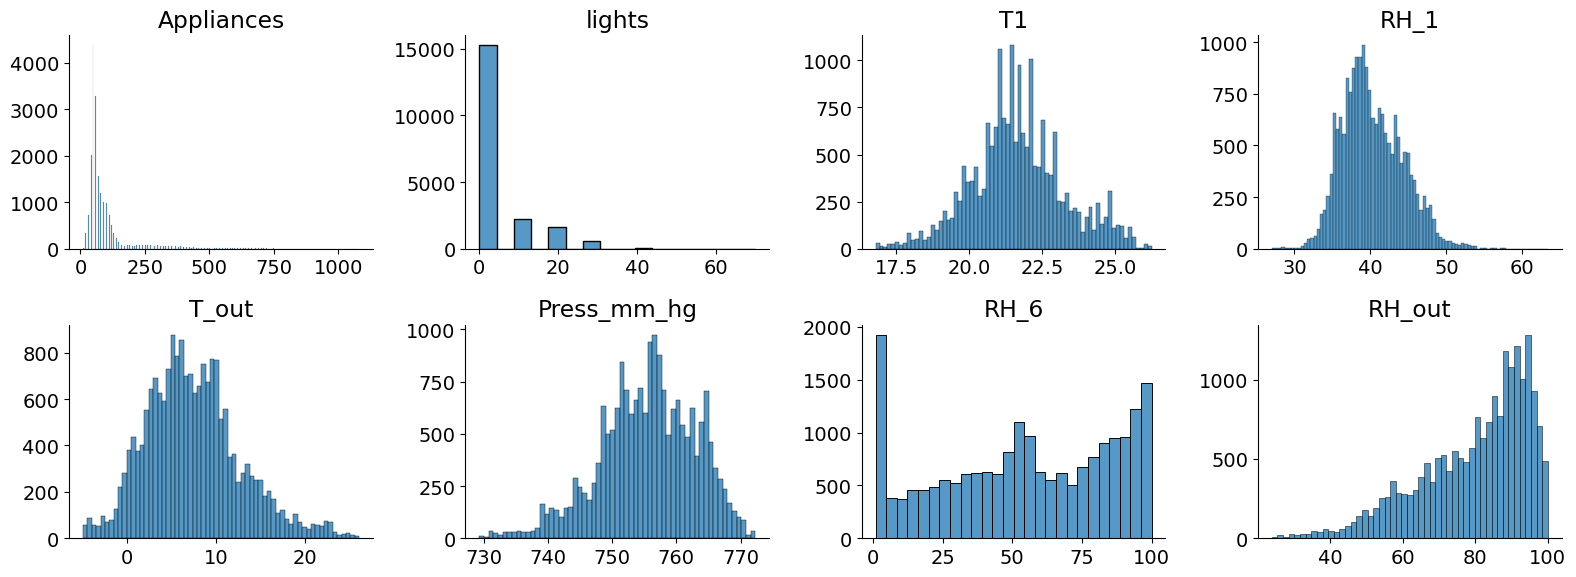

In [16]:
histplots_grid(2, 4, data, features = ["Appliances", "lights", "T1", "RH_1", "T_out", "Press_mm_hg", "RH_6", "RH_out"])

In [167]:
# histplots_grid(1, 4, data, features = ["RH_6", "RH_out", "rv1", "rv2"])

In [177]:
pd.set_option("display.max_rows", None)
data[["T6", "RH_6", "T_out", "RH_out"]]
(data.RH_6 < 24.0).mean()

0.2072966810235622

## Looking at energy consumption over the entire time period covered by the data

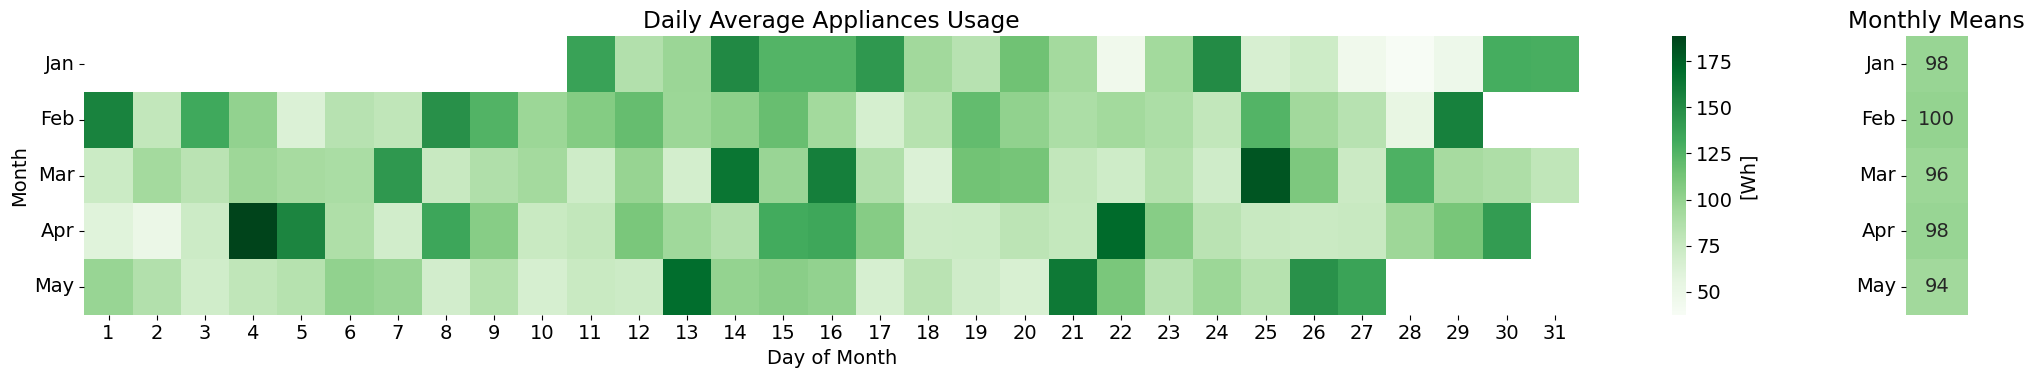

In [17]:
energy_consumption_all_time(data.Appliances)

In [185]:
def energy_vs_lights_plot(appliances, lights):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 4))
    ax1.set_xlabel('Time')

    sns.lineplot(x=range(len(appliances)), y=appliances, ax=ax1, linestyle="-", label="Appliances energy consumption")
    ax1.set_ylabel('Appliances [Wh]')
    ax1.set_title("General energy consumptions vs. lights energy consumption")

    ax2 = ax1.twinx()
    sns.lineplot(x=range(len(lights)), y=lights, ax=ax2, color="yellow", linestyle="-", label="Light energy consumption", alpha=0.6)
    ax2.set_ylabel('Lights [Wh]')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.show()

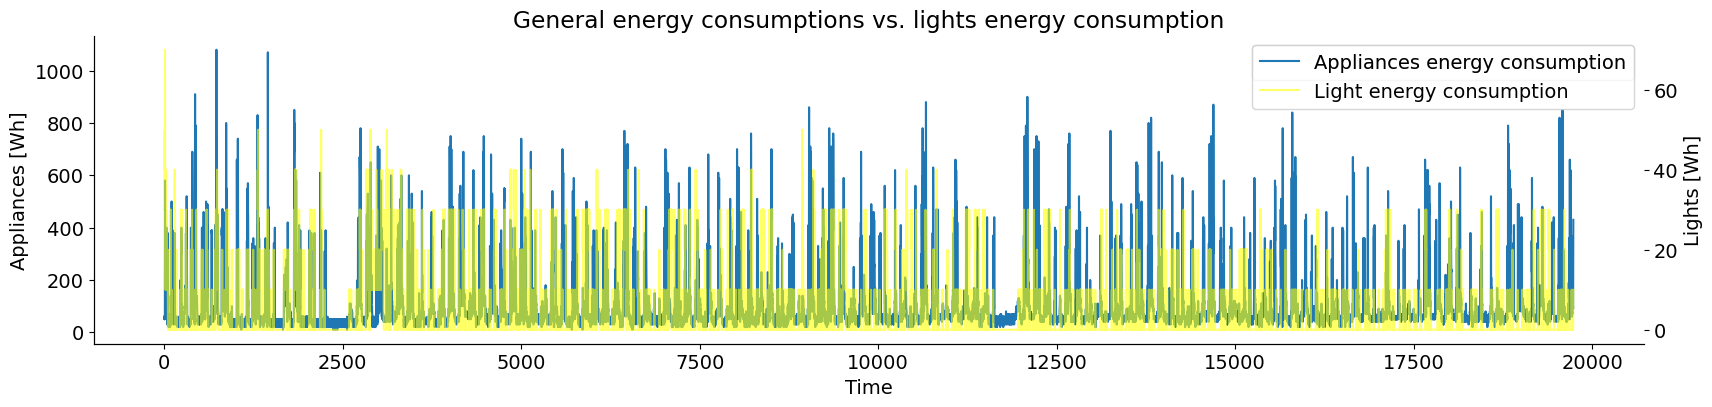

In [186]:
energy_vs_lights_plot(data.Appliances, data.lights)

https://en.wikipedia.org/wiki/Belgium#Geography

https://www.timeanddate.com/holidays/belgium/2016

In [122]:
days_to_remove = ['2016-01-27', '2016-01-28', '2016-01-29', '2016-04-01', '2016-04-02']
days_to_remove = pd.to_datetime(days_to_remove)

data = data[~data.index.normalize().isin(days_to_remove)]

## Feature engineering

In [14]:
data["day_of_week"] = data.index.day_of_week

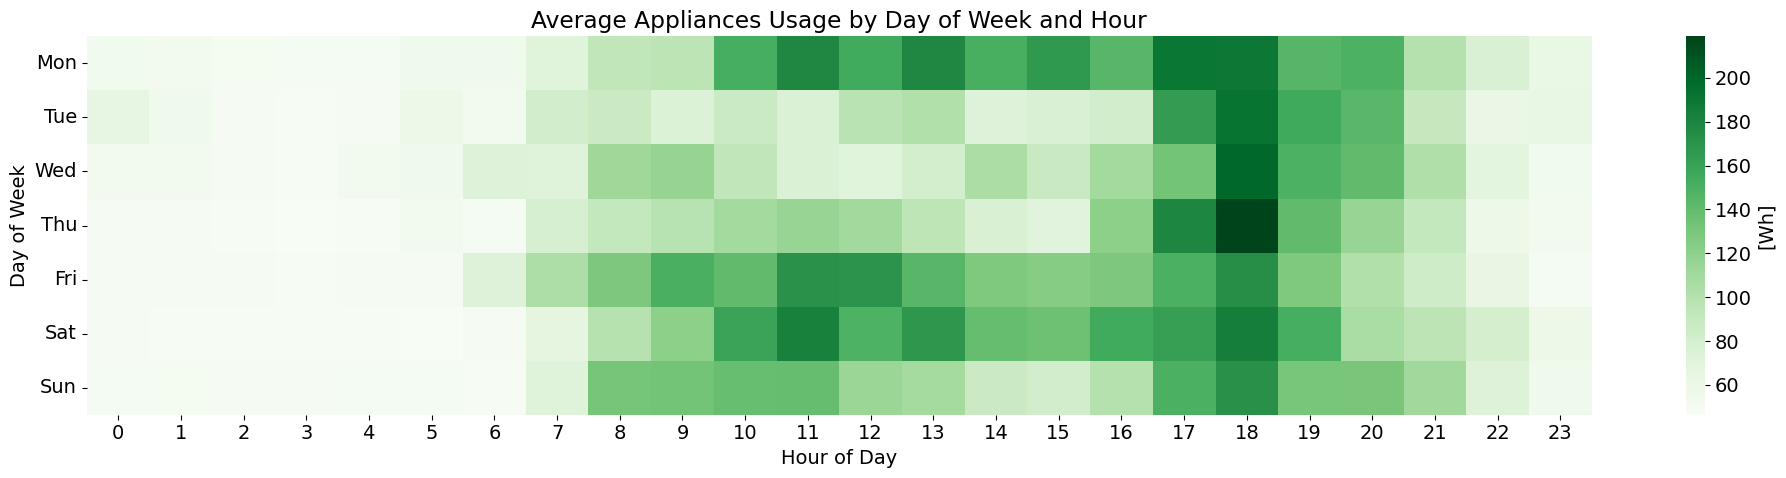

In [13]:
data["day_of_week"] = data.index.day_name()
data["hour"] = data.index.hour

consumption_by_day_and_hour(data[["Appliances", "day_of_week", "hour"]])

In [5]:
def add_lagged_features(data, lag, how_many):
    
    data_t = data.copy()
    
    lagged_columns = [data_t.Appliances.shift(i*lag).rename(f"lag_{i}") for i in range(1, how_many+1)]
    data_t = pd.concat([data_t] + lagged_columns, axis=1)
    data_t.dropna(inplace = True)

    return data_t

In [108]:
data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)

data = add_lagged_features(data, lag=1, how_many=24*6)

X = data.drop("Appliances", axis = 1)
y = data.Appliances

In [109]:
X = data.drop("Appliances", axis = 1)
y = data.Appliances

In [110]:
X.shape

(19591, 168)

In [78]:
X.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,day_of_week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 05:00:00,0,20.100000,46.363333,19.500000,44.79,20.290000,45.59,19.760000,46.590000,18.5000,50.000,4.800000,94.126667,17.89,45.663333,19.100000,54.290,17.1,49.260000,5.00,739.900000,91.000000,5.000000,40.0,3.60,17.334174,17.334174,60.0,40.0,40.0,40.0,50.0,40.0,50.0,50.0,40.0,20.0,20.0,30.0,40.0,40.0,50.0,50.0,50.0,40.0,50.0,40.0,50.0,120.0,370.0,380.0,380.0,310.0,50.0,40.0,30.0,40.0,40.0,60.0,70.0,50.0,60.0,60.0,60.0,240.0,390.0,400.0,400.0,110.0,100.0,100.0,100.0,100.0,110.0,110.0,110.0,110.0,190.0,120.0,140.0,80.0,70.0,90.0,100.0,100.0,250.0,430.0,580.0,230.0,70.0,60.0,60.0,60.0,50.0,60.0,50.0,50.0,60.0,60.0,Tuesday
2016-01-12 05:10:00,0,20.100000,46.500000,19.426667,44.73,20.290000,45.59,19.700000,46.663333,18.4725,49.975,4.800000,94.000000,17.89,45.590000,19.100000,54.230,17.1,49.290000,4.98,739.966667,91.666667,4.833333,40.0,3.68,16.688747,16.688747,50.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,50.0,40.0,20.0,20.0,30.0,40.0,40.0,50.0,50.0,50.0,40.0,50.0,40.0,50.0,120.0,370.0,380.0,380.0,310.0,50.0,40.0,30.0,40.0,40.0,60.0,70.0,50.0,60.0,60.0,60.0,240.0,390.0,400.0,400.0,110.0,100.0,100.0,100.0,100.0,110.0,110.0,110.0,110.0,190.0,120.0,140.0,80.0,70.0,90.0,100.0,100.0,250.0,430.0,580.0,230.0,70.0,60.0,60.0,60.0,50.0,60.0,50.0,50.0,60.0,Tuesday
2016-01-12 05:20:00,0,20.033333,46.360000,19.390000,44.73,20.290000,45.59,19.666667,46.663333,18.3900,49.900,4.763333,93.563333,17.89,45.590000,19.050000,54.045,17.1,49.363333,4.97,740.033333,92.333333,4.666667,40.0,3.77,23.817562,23.817562,50.0,50.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,50.0,40.0,20.0,20.0,30.0,40.0,40.0,50.0,50.0,50.0,40.0,50.0,40.0,50.0,120.0,370.0,380.0,380.0,310.0,50.0,40.0,30.0,40.0,40.0,60.0,70.0,50.0,60.0,60.0,60.0,240.0,390.0,400.0,400.0,110.0,100.0,100.0,100.0,100.0,110.0,110.0,110.0,110.0,190.0,120.0,140.0,80.0,70.0,90.0,100.0,100.0,250.0,430.0,580.0,230.0,70.0,60.0,60.0,60.0,50.0,60.0,50.0,50.0,Tuesday
2016-01-12 05:30:00,0,20.000000,46.290000,19.390000,44.79,20.356667,45.59,19.600000,46.590000,18.3900,49.900,4.763333,94.023333,17.89,45.626667,19.000000,54.000,17.1,49.433333,4.95,740.100000,93.000000,4.500000,40.0,3.85,44.609917,44.609917,40.0,50.0,50.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,50.0,40.0,20.0,20.0,30.0,40.0,40.0,50.0,50.0,50.0,40.0,50.0,40.0,50.0,120.0,370.0,380.0,380.0,310.0,50.0,40.0,30.0,40.0,40.0,60.0,70.0,50.0,60.0,60.0,60.0,240.0,390.0,400.0,400.0,110.0,100.0,100.0,100.0,100.0,110.0,110.0,110.0,110.0,190.0,120.0,140.0,80.0,70.0,90.0,100.0,100.0,250.0,430.0,580.0,230.0,70.0,60.0,60.0,60.0,50.0,60.0,50.0,Tuesday
2016-01-12 05:40:00,0,20.000000,46.290000,19.390000,44.79,20.390000,45.59,19.600000,46.626667,18.3900,49.900,4.833333,94.726667,17.89,45.626667,19.066667,54.000,17.1,49.560000,4.93,740.166667,93.666667,4.333333,40.0,3.93,43.216974,43.216974,40.0,40.0,50.0,50.0,60.0,40.0,40.0,40.0,50.0,40.0,50.0,50.0,40.0,20.0,20.0,30.0,40.0,40.0,50.0,50.0,50.0,40.0,50.0,40.0,50.0,120.0,370.0,380.0,380.0,310.0,50.0,40.0,30.0,40.0,40.0,60.0,70.0,50.0,60.0,60.0,60.0,240.0,390.0,400.0,400.0,110.0,100.0,100.0,100.0,100.0,110.0,110.0,110.0,110.0,190.0,120.0,140.0,80.0,70.0,90.0,100.0,100.0,250.0,430.0,580.0,230.0,70.0,60.0,60.0,60.0,50.0,60.0,Tuesday


In [ ]:
data["week_of_year"] = data.index.isocalendar().week
grouped_by_week = data.groupby("week_of_year")
grouped_by_week.Appliances.mean()

## Experiments

In [351]:
n_train = int(0.9 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

mlflow.set_experiment("MLflow Energy_1")

params = {"min_samples_leaf":20, "max_features": 0.5}
model = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), 
                                              remainder="passthrough"), 
                      ExtraTreesRegressor(**params))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)


with mlflow.start_run():

    mlflow.log_params(params)
    mlflow.log_metric("mape", mape)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "ExtraTreeRegressor, 1 exp")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="energy_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="ETR_1",
    )

In [111]:
n_train = int(0.9 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

# pipe = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), HistGradientBoostingRegressor())
model = TransformedTargetRegressor(HistGradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.18887049784440543

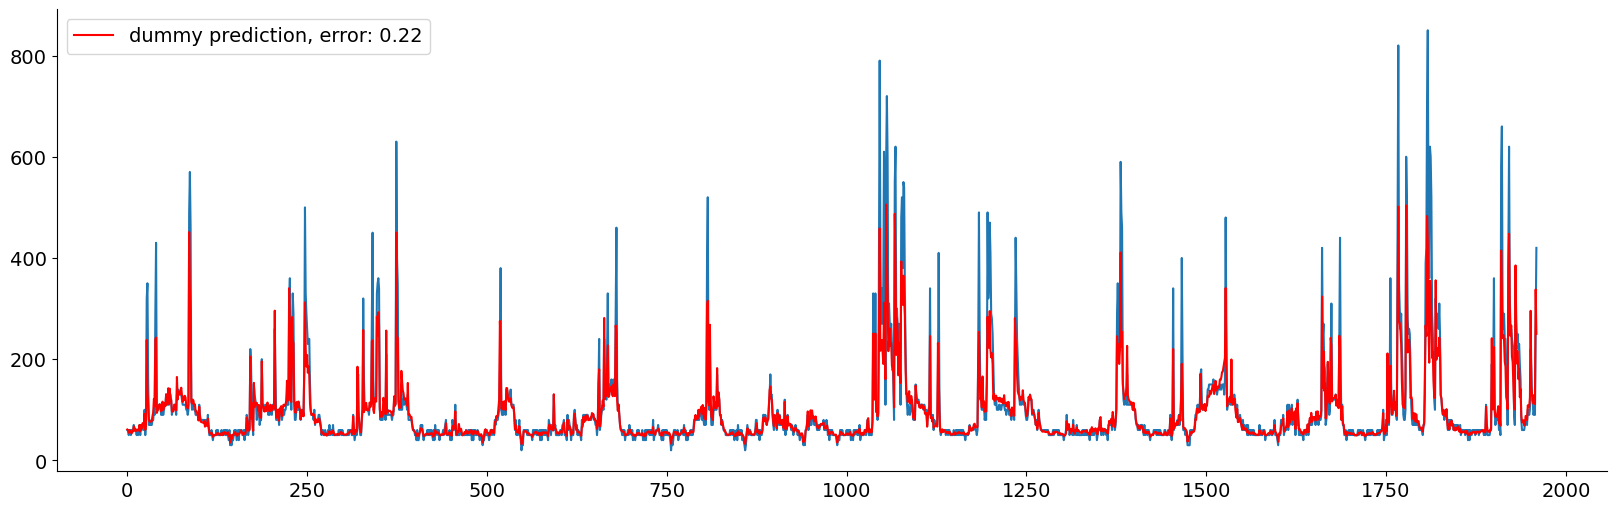

In [112]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), X_test.lag_1)
plt.plot(range(0, X_test.shape[0]), y_pred,
        color="red", label=f"dummy prediction, error: {mean_absolute_percentage_error(y_test, X_test.lag_1).round(2)}")
plt.legend()
plt.show()

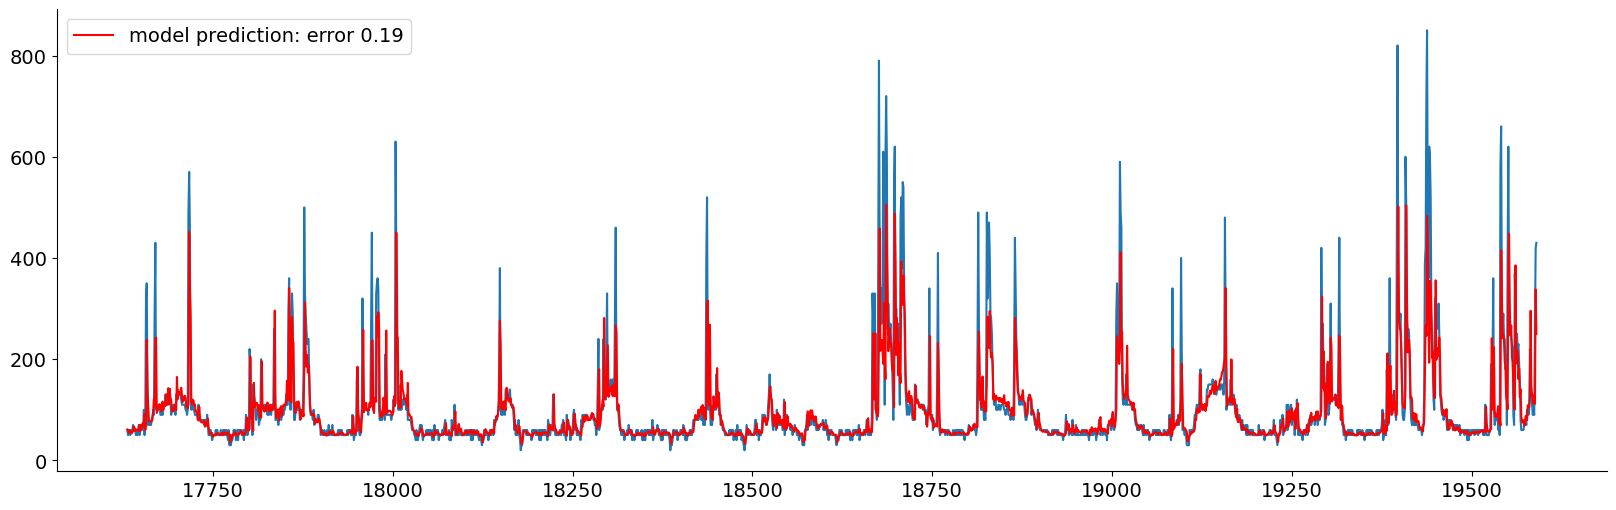

In [113]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(17631, N), data.Appliances[17631:])
plt.plot(range(n_train, N), y_pred,
        color="red", label=f"model prediction: error {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
plt.legend()
plt.show()

In [139]:
all_results = {}

for mod in [LinearRegression(), 
              Ridge(), 
              Lasso(), 
              DecisionTreeRegressor(min_samples_leaf=50),
              ExtraTreesRegressor(min_samples_leaf=20), 
              RandomForestRegressor(min_samples_leaf=20), 
              BaggingRegressor(n_estimators=100, max_samples=0.5), 
              HistGradientBoostingRegressor(),
            XGBRegressor()]:

    results = {}
    model = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), mod)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    err = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results["mape"] = err
    results["mse"] = mse
    
    all_results[model[1].__class__.__name__] = results
    
df = pd.DataFrame.from_dict(all_results, 
                            orient = "index", 
                            columns = ["mape", "mse"])

In [140]:
df

,mape,mse
LinearRegression,0.269640,3773.874890
Ridge,0.269631,3773.870897
Lasso,0.244734,3782.825282
DecisionTreeRegressor,0.245823,3856.027515
ExtraTreesRegressor,0.227801,3483.317708
RandomForestRegressor,0.226660,3510.136789
BaggingRegressor,0.264641,3807.859274
HistGradientBoostingRegressor,0.220979,3482.322171


### Target +24h

In [116]:
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data.set_index("date", inplace = True)

data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)
data["day_of_week"] = data.index.day_of_week
data["hour"] = data.index.hour
data = add_lagged_features(data, lag=1, how_many=24*6)

In [117]:
data.Appliances = data.Appliances.shift(-24*6)
data.dropna(inplace=True)

In [118]:
# data = add_lagged_features(data, lag=1, how_many=24*6)

X = data.drop("Appliances", axis = 1)
y = data.Appliances

In [120]:
n_train = int(0.9 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

In [121]:
# pipe = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), HistGradientBoostingRegressor())
model = TransformedTargetRegressor(ExtraTreesRegressor(min_samples_leaf=20), func=np.log1p, inverse_func=np.expm1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.2861541734368889

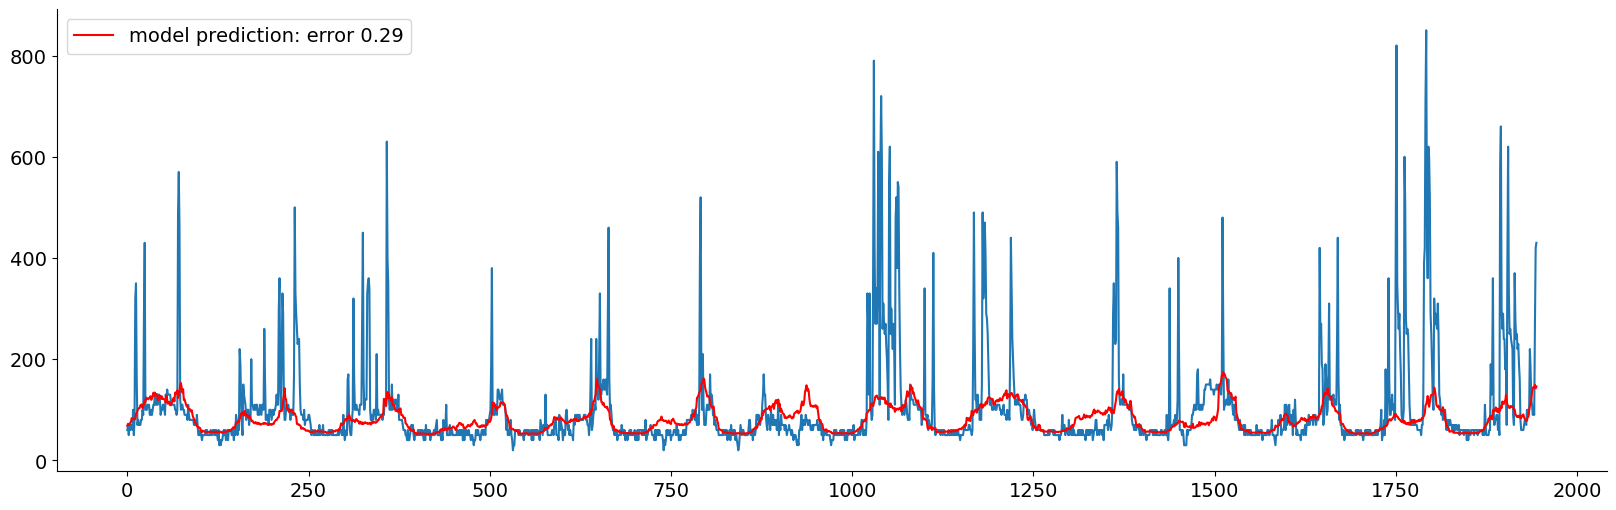

In [122]:
# N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), y_test)
plt.plot(range(0, X_test.shape[0]), y_pred,
        color="red", label=f"model prediction: error {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
plt.legend()
plt.show()

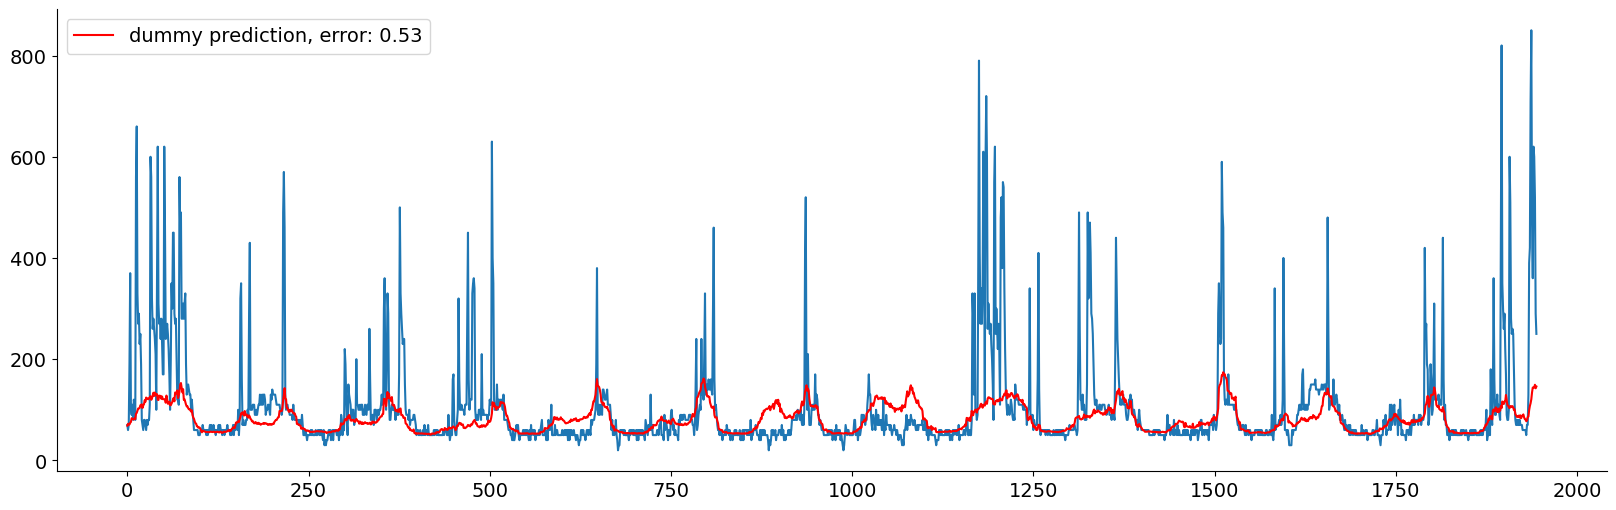

In [123]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), X_test.lag_1)
plt.plot(range(0, X_test.shape[0]), y_pred,
        color="red", label=f"dummy prediction, error: {mean_absolute_percentage_error(y_test, X_test.lag_1).round(2)}")
plt.legend()
plt.show()